In [1]:
import os
import csv
from math import ceil
import os

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

import modin.pandas as mpd
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
tf.test.is_built_with_cuda()

Using TensorFlow backend.


True

### Check to make sure Tensorflwo can see my GPU

In [2]:
print("Tensorflow Version: {}".format(tf.__version__))
print("Keras Version: {}".format(keras.__version__))
print(tf.test.is_gpu_available())
assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Tensorflow Version: 1.15.0
Keras Version: 2.0.9
True
Default GPU Device: /device:GPU:0


### Load training data from csv into pandas dataframe

In [3]:
######################################
### Load data from csv file into list
######################################
# Simulation data folder path
sim_data_fld = './simulation_data'

# CSV data file name
csv_data_file = 'driving_log.csv'

# Training data folders
data_flds = os.listdir(sim_data_fld)
print(data_flds)

# List to store lines of data from csv's
lines = []

# Loop through simulation data folders
for fld in data_flds:
    # Create data path
    data_path = os.path.join(sim_data_fld, fld, csv_data_file)

    # Open csv file
    with open(data_path) as csvfile:
        print("Opening {}".format(data_path))
        
        # Read data from csv file
        reader = csv.reader(csvfile)
        
        # Grab each line from csv and append to list
        for line in reader: 
            lines.append(line)

print("Found {} images for training".format(len(lines)*3))

#####################################
### save list into pandas dataframe
#####################################
df_columns = ['center', 'left', 'right', 'angle', 'throttle', 'brake', 'speed']

t_data_df = pd.DataFrame(lines, columns=df_columns)

t_data_df['angle'] = t_data_df['angle'].astype('float32')
t_data_df['throttle'] = t_data_df['throttle'].astype('float32')
t_data_df['angle'].dtype

t_data_df['center'] = t_data_df.center.str.replace('/home/shane/dev/udacity_self_driving_car_engineer/', '/home/slicari/dev/udacity/')
t_data_df['right'] = t_data_df.right.str.replace('/home/shane/dev/udacity_self_driving_car_engineer/', '/home/slicari/dev/udacity/')
t_data_df['left'] = t_data_df.left.str.replace('/home/shane/dev/udacity_self_driving_car_engineer/', '/home/slicari/dev/udacity/')

print(t_data_df['center'].iloc[0])
print(t_data_df.shape)

['track2_cclockwise', 'track2_clockwise', 'track2_clockwise2_inlane', 'track1_cclockwise1', 'track1_clockwise1']
Opening ./simulation_data/track2_cclockwise/driving_log.csv
Opening ./simulation_data/track2_clockwise/driving_log.csv
Opening ./simulation_data/track2_clockwise2_inlane/driving_log.csv
Opening ./simulation_data/track1_cclockwise1/driving_log.csv
Opening ./simulation_data/track1_clockwise1/driving_log.csv
Found 34374 images for training
/home/slicari/dev/udacity/CarND-Behavioral-Cloning-P3/simulation_data/track2_cclockwise/IMG/center_2020_07_03_11_22_55_403.jpg
(11458, 7)


### Use a training generator for the dataset

In [8]:
import sys
# Get list for features and list for labels
# Features will be input images from udacity simulation (160, 320, 3)
# Labels will be steering wheel angle (float)
train_mode = "steering"

def training_generator(samples, batch_size=32):
    num_samples = len(samples)
    
    while 1: # Loop so generator never terminates
        shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # Open center, left and right images
                center_image = cv2.cvtColor(cv2.imread(batch_sample[0]), cv2.COLOR_BGR2RGB)
                left_image = cv2.cvtColor(cv2.imread(batch_sample[1]), cv2.COLOR_BGR2RGB)
                right_image = cv2.cvtColor(cv2.imread(batch_sample[2]), cv2.COLOR_BGR2RGB)



                # Cropt out the top and bottom of the image to remove the sky
                # and hood of the car so the model doesn't consider these features while training
    #             center_image = center_image[50:140,]
    #             left_image = left_image[50:140,]
    #             right_image = left_image[50:140,]

                # Resize image to 66x200
    #             center_image = cv2.resize(center_image,(200, 66))
    #             left_image = cv2.resize(center_image,(200, 66))
    #             right_image = cv2.resize(center_image,(200, 66))


                # Add image preprocessing here if needed
                # Try to do most processing as labmda layer so operations
                # are runing in parallel using gpu 
#                 if train_mode == "steering":
                # Get steering angle 
                angle_center = batch_sample[3]

                correction = 0.2
                angle_left = angle_center + correction
                angle_right = angle_center - correction

                # Append image to list
                images.extend((center_image, left_image, right_image))

                # Append steering angle to list
                angles.extend((angle_center, angle_left, angle_right))

                augmented_images, augmented_angles = [], []    
                for image, angle in zip(images, angles):
                    augmented_images.append(image)
                    augmented_angles.append(angle)
                    augmented_images.append(cv2.flip(image, 1))
                    augmented_angles.append(angle * -1)
                    
#                 elif train_mode == "throttle":
#                     # Get throttle value
#                     throttle = batch_sample[4]

#                     correction = 0.1
#                     throttle_left = throttle + correction
#                     throttle_right = throttle - correction

#                     # Append image to list
#                     images.extend((center_image, left_image, right_image))

#                     # Append steering angle to list
#                     angles.extend((throttle, throttle_left, throttle_right))
                    
#                     augmented_images, augmented_angles = [], []    
#                     for image, angle in zip(images, angles):
#                         augmented_images.append(image)
#                         augmented_angles.append(angle)
#                         augmented_images.append(cv2.flip(image, 1))
#                         augmented_angles.append(angle)
                    
#                 else:
#                     print("Train mode not valid.")
#                     sys.exit()


            # Convert feature list to numpy array for training
            X_train = np.array(augmented_images)

            # Convert label list to numpy array for training
            y_train = np.array(augmented_angles)

            # Ensure x_train and y_train have same length
            assert(len(X_train) == len(y_train))

            # Shuffle and yeild data
            yield shuffle(X_train, y_train)

# Set batch size for generator
batch_size = 128

# Convert df values to list
samples = t_data_df.values.tolist()

# Create training samples and validation samples
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# Call training generator
train_generator = training_generator(train_samples, batch_size=batch_size)
validation_generator = training_generator(train_samples, batch_size=batch_size)


### Run preprocess function using Ray

In [4]:
%%time

import ray
import psutil

# Convert df values to list
samples = t_data_df.values.tolist()

num_cpus = psutil.cpu_count(logical=True)

ray.shutdown()

# Initialize Ray
ray.init(num_cpus=num_cpus)

@ray.remote
def image_preprocess(sample):
    
    img_tup = ()
    angle_tup = ()
    
    # Open center, left and right images
    center_image = cv2.cvtColor(cv2.imread(sample[0]), cv2.COLOR_BGR2RGB)
    left_image = cv2.cvtColor(cv2.imread(sample[1]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(sample[2]), cv2.COLOR_BGR2RGB)
    
    angle_center = sample[3]

    correction = 0.2
    angle_left = angle_center + correction
    angle_right = angle_center - correction
    
    img_tup = img_tup + (center_image, left_image, right_image)
    angle_tup = angle_tup + (angle_center, angle_left, angle_right)
    
    
    if angle_center > 0:
        aug_center_image = (cv2.flip(center_image, 1))
        aug_center_angle = (angle_center * -1)
        img_tup = img_tup + (aug_center_image,)
        angle_tup = angle_tup + (aug_center_angle,)
    
    aug_left_image = (cv2.flip(left_image, 1))
    aug_left_angle = (angle_left * -1)
    
    aug_right_image = (cv2.flip(right_image, 1))
    aug_right_angle = (angle_right * -1)
    
    img_tup = img_tup + (aug_left_image, aug_right_image)
    angle_tup = angle_tup + (aug_left_angle, aug_right_angle)

    return(img_tup, angle_tup)


augmented_data = []
for sample in samples:
    augmented_data.append(image_preprocess.remote(sample))


results = ray.get(augmented_data)

import itertools
print(len(results))
print(type(results))

train_data = list(zip(*results))
x_train_lst = list(itertools.chain(*train_data[0]))
y_train_lst = list(itertools.chain(*train_data[1]))

X_train = np.array(x_train_lst)
y_train = np.array(y_train_lst)

2020-07-17 11:18:40,239	INFO resource_spec.py:212 -- Starting Ray with 35.55 GiB memory available for workers and up to 17.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-17 11:18:40,504	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-07-17 11:18:40,778	INFO services.py:1165 -- View the Ray dashboard at localhost:8266


CPU times: user 3.28 s, sys: 852 ms, total: 4.13 s
Wall time: 6.23 s


In [9]:
from keras.models import Sequential
from keras.utils import multi_gpu_model
from keras.layers import Lambda, Cropping2D 
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
import tensorflow as tf

batch_size = 512
# model = Sequential()
# model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))
# model.add(Lambda(lambda x: x / 255.0 - 0.5))
# model.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'))
# model.add(MaxPooling2D(strides=(2,2)))
# model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'))       
# model.add(MaxPooling2D(strides=(2,2)))
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(120, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(84, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))

# """
# Modified NVIDIA model
# """
model = Sequential()

# # Normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((50, 20), (0, 0))))
model.add(Conv2D(24, (5, 5), activation='relu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='relu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='relu', strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()

#parallel_model = multi_gpu_model(model, gpus=2)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history_object = model.fit_generator(train_generator, steps_per_epoch=ceil(len(train_samples)/batch_size), validation_data=validation_generator, validation_steps=ceil(len(validation_samples)/batch_size), epochs=5, verbose=1)

#history_object = parallel_model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=2, batch_size=batch_size)

model.save('steering_model.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_3 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 33, 64)         36928     
__________

dict_keys(['val_loss', 'loss'])


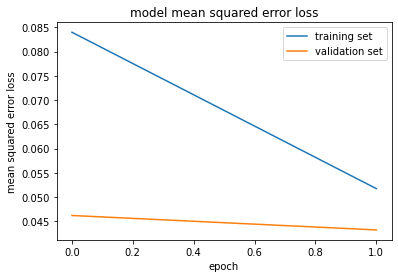

In [9]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()